<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP
## Truth or Truth

# Data Cleaning and EDA
---

## Table of Contents:
- [Cleaning](#cleaning)
- [Exploratory Data Analysis](#eda)
- [Next Step](#next_step_3)

## Imports

In [755]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pandas as pd
import seaborn as sns
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import html
import re
from scipy.stats import iqr
from langdetect import detect, DetectorFactory
from wordcloud import WordCloud, STOPWORDS
pd.set_option('display.max_rows', None)

In [544]:
#Import r/conspiracy and r/news dataframes
df_c = pd.read_csv("../data/reddit_conspiracy/merged/conspiracy_posts.csv")
df_n = pd.read_csv("../data/reddit_news/merged/news_posts.csv")

## Cleaning<a id='cleaning'></a>
---

In [545]:
#check for null values
pd.DataFrame([df_c.isnull().sum(),df_n.isnull().sum()], index=["Conspiracy","News"]).T

,Conspiracy,News
subreddit,0,0
title,0,0
utc_datetime_str,0,0


In [546]:
#remove rows with content from promoted user news sources
#only present in r/news posts
drop_content = df_n.loc[df_n["subreddit"] != "news"].index
df_n.drop(index = drop_content,inplace = True)

In [547]:
#concatenate r/news and r/conspiracy dataframes
df = pd.concat([df_c,df_n],ignore_index=True)

In [548]:
#remove rows with no title content
no_content = df.loc[df["title"] == "[deleted by user]"].index
df.drop(index = no_content,inplace = True)

In [549]:
#remove title duplicates
df.drop_duplicates(subset = ["title"],inplace = True)

### Preprocessing & Feature Engineering
---

In [550]:
#replace html character references with unicode equivalent
#Source - https://docs.python.org/3/library/html.html#html.unescape
df['title'] = df['title'].apply(html.unescape)

In [551]:
#language detection module - https://pypi.org/project/langdetect/
#detect language of each post text

#make results consistent
DetectorFactory.seed = 0

#detect language of text
def language_detect(txt):
    try:
        return detect(txt)
    except: #prevent errors from halting function
        return "unknown"
    
#create column with language of post text
df["language"] = df["title"].map(lambda x : language_detect(x))

In [552]:
#remove foreign language posts text
for language in list(df.language.unique()):
    if language != 'en':
        drop_index = df.loc[df["language"] == language].index
        df.drop(index = drop_index,inplace = True)

In [553]:
#custom preprocessor

#web link removal
'''Source - https://stackoverflow.com/questions/53962844/
applying-regex-across-entire-column-of-a-dataframe'''

def custom_preprocessor(df):
    
    #remove web links in title
    df['title'] =  [re.sub(r'https?:\/\/.*\/\w*','', str(x)) for x in df['title']]
    df['title'] =  [re.sub(r'[\S]*\.com[\S]*','', str(x)) for x in df['title']]

    #delete cells that only contained a web link and are now empty
    empty_index = df[df['title'] == ''].index
    df.drop(index = empty_index,inplace = True)

    #replace "-" and "_" with space
    df['title'] = df['title'].str.replace('-',' ')
    df['title'] = df['title'].str.replace('_',' ')
    
custom_preprocessor(df)

In [554]:
#create title length variable
df["title_length"] = df.title.apply(len)

In [555]:
#create word count variable
df["title_word_count"] = df.title.map(lambda txt: len(txt.split()))

In [556]:
#create sentiment analysis variable containing compound polarity score
sent = SentimentIntensityAnalyzer()

def compound_sentiment(txt):
    return sent.polarity_scores(txt)['compound']

df["sentiment"] = df["title"].apply(compound_sentiment)

In [557]:
#create sentiment category variable
df["sentiment_category"] = df["sentiment"].map(lambda x: "Negative" if x < 0\
                                               else "Neutral" if x == 0 else "Positive")

In [558]:
#convert the utc_datetime_str column into datetime type
df["utc_datetime_str"] = pd.to_datetime(df["utc_datetime_str"])

In [559]:
#extract hour and categorize based on time of day
#Source - https://stackoverflow.com/questions/61282679/how-to-extract-hours-from-a-pandas-datetime
#parts of day
#Source - https://www.britannica.com/dictionary/eb/qa/parts-of-the-day-early-morning-late-morning-etc
df["hour"] = df["utc_datetime_str"].dt.hour
df["hour"] = df["hour"].map(lambda x : "morning" if 5 <= x <= 12 
                           else "afternoon" if 12 < x <= 17
                           else "evening" if 17 < x <= 21
                           else "night")

In [561]:
#sava dataframe
df.to_csv("../data/cleaned_data/conspiracy_news.csv", index = False)

## Exploratory Data Analysis<a id='eda'></a>
---

In [562]:
#check shape of data
df.shape

(15671, 9)

In [563]:
#check balance of classes
df["subreddit"].value_counts(normalize = True)

conspiracy    0.560015
news          0.439985
Name: subreddit, dtype: float64

**Data is slightly imbalanced.**

In [564]:
#separate dataframe for easier plotting and analysis
df_c = df[df["subreddit"] == "conspiracy"]
df_n = df[df["subreddit"] == "news"]

In [766]:
# Source - https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python

def show_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=STOPWORDS,
        max_words=200,
        max_font_size=40, 
        scale=5,
        random_state=42,
        min_word_length=3
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud, interpolation="blackman")
    wordcloud.to_file(f"../images/{title.replace(' ', '_')[2:]}.png")
    plt.show()

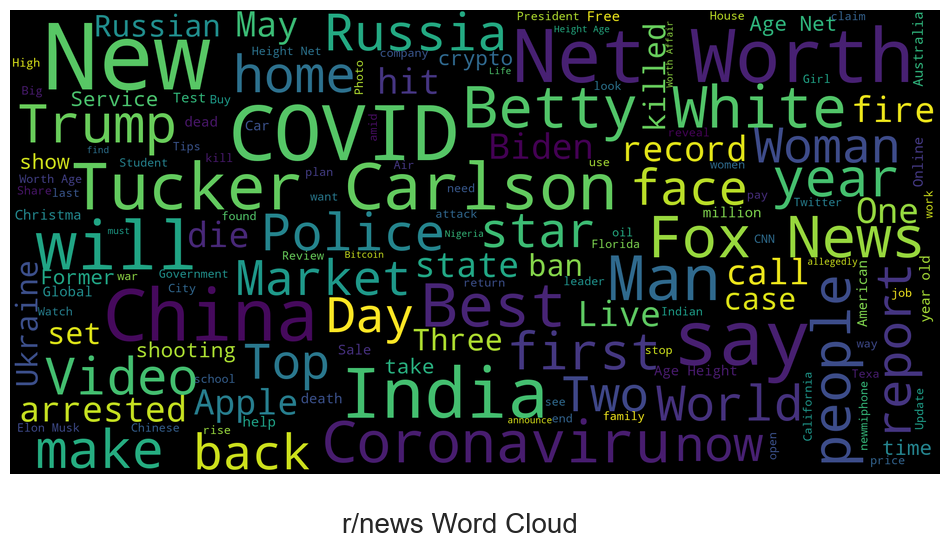

In [767]:
show_wordcloud(df_n["title"], 'r/news Word Cloud')

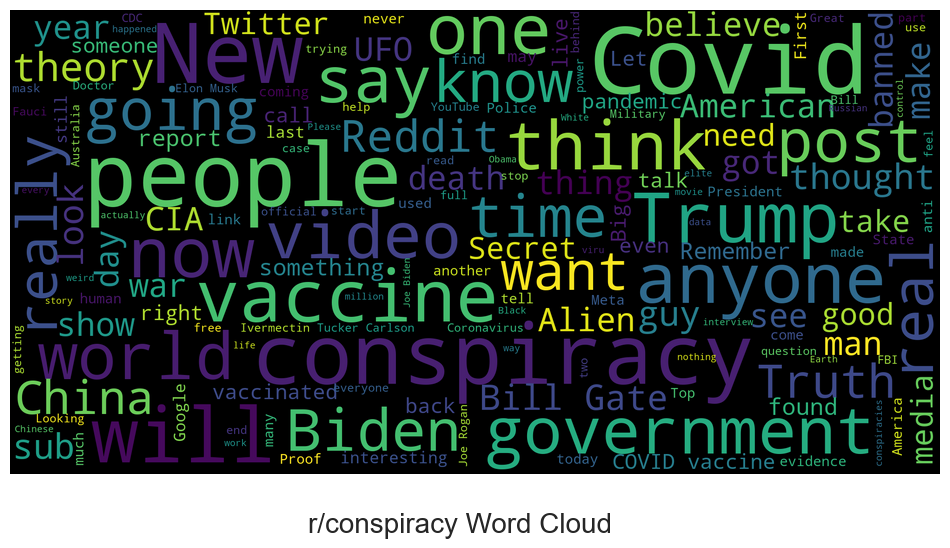

In [768]:
show_wordcloud(df_c["title"], 'r/conspiracy Word Cloud')

### Word Count and Length

In [565]:
# 10 shortest posts for conspiracy
df_c.sort_values(by = ["title_word_count"])\
[["title",'title_word_count']].head(10)

,title,title_word_count
3760,Exposed,1
8168,Interesting….,1
4658,Manifestations,1
3068,Covid19,1
4656,Facts,1
1447,Reactionaries,1
869,Theory:,1
3168,S.earch,1
3228,DoItQ,1
1694,Hopefully,1


In [566]:
# 10 shortest posts for news
df_n.sort_values(by = ["title_word_count"])\
[["title",'title_word_count']].head(10)

,title,title_word_count
15738,Qorting,1
12159,News,1
10177,GoodDealChem,1
15097,Flashscore24,1
15520,Bloboff,1
11881,Twitter,1
14932,untitled,1
13323,EnergyAustralia Reviews,2
15094,Car Bed,2
13457,ActewAGL Reviews,2


In [567]:
# 10 longest posts by word count for conspiracy
df_c.sort_values(by = ["title_word_count"],ascending = False)[["title",'title_word_count']].head(10)

,title,title_word_count
4403,This is a 'Kryptos' follow up... After reviewi...,60
6900,Here's a 360° camera sent up 120k feet on a ba...,59
4281,At CIA Headquarters is an iron 'art form' he...,59
4585,I believe I have to repost this adding what is...,59
6659,wondering why on the Chemtrail page 🤔 for exam...,59
4185,Best Alex Jones quotes on NASA. He says NASA h...,59
9128,FROM BUSY & BROKE TO PRODUCTIVE AND RICH Are y...,59
3017,"If we contemplate this person, he is outside t...",58
828,Kicked offline on call of duty after speaking ...,58
4311,Storm The Vatican seriously people did it for ...,57


In [568]:
# 10 longest posts by word count for news
df_n.sort_values(by = ["title_word_count"],ascending = False)[["title",'title_word_count']].head(10)

,title,title_word_count
10362,Face Yoga: All Face Yoga Questions and Answers...,54
12807,Coronavirus Outbreak India Cases LIVE Updates;...,51
18373,Have news concerning where border crossers are...,50
13873,Dance video of 60 doctors on goes viral on soc...,49
12299,"To the Boğaziçi, one of the best university in...",49
12713,banking ; online banking ; IDBI Bank will now ...,49
12034,Powerful Motivation from Daniel creator of Dai...,49
12419,"In Zimbabwe, 17 year old Marisa teaches Taekwo...",49
18577,"Turns out, “camp counselor” dev manager hires ...",48
18759,Do you want to date live video calls with beau...,48


In [569]:
#summary statistics for r/conspiracy post length and word count
df_c[["title_length","title_word_count"]].describe().T

,count,mean,std,min,25%,50%,75%,max
title_length,8776.0,88.952484,67.077915,4.0,42.0,69.0,113.0,300.0
title_word_count,8776.0,15.112466,11.466378,1.0,7.0,12.0,19.0,60.0


In [570]:
df_n[["title_length","title_word_count"]].describe().T

,count,mean,std,min,25%,50%,75%,max
title_length,6895.0,76.877012,38.948442,4.0,55.0,69.0,88.0,300.0
title_word_count,6895.0,12.546628,6.383326,1.0,9.0,11.0,14.0,54.0


On average (according to the mean), r/conspiracy posts are longer and contain slightly more words than the posts found on r/news. Title length and word count variables have much higher variance in r/conspiracy. This indicates a greater spread of these values around their respective means. This contrasting spread can also be easily seen by noticing the range between the first/second quartiles and the second/thrid quartiles of the title length variable. Otherwise, variables have mostly similar ranges and median values compared across subreddits. 

In [727]:
#create custom comparison histplots

sns.set(style="darkgrid")

def custom_histplot(variable, x_label, plot_title, main_title):
    fig,ax = plt.subplots(1,2, figsize = (12,6), sharex=True,sharey = True)

    sns.histplot(df_c[variable],ax=ax[0], bins = 50, color = "darkorange")
    ax[0].set_xlabel(x_label, fontsize = 14)
    ax[0].set_ylabel("Count",fontsize = 14)
    ax[0].set_title(f"r/conspiracy {plot_title}", fontweight = "bold", fontsize = 14)
    ax[0].axvline(df_c[variable].mean(), linestyle='dotted', color='purple', linewidth=3)

    sns.histplot(df_n[variable],ax=ax[1],bins = 50, color = "lightseagreen")
    ax[1].set_xlabel(x_label, fontsize = 14)
    ax[1].set_ylabel("Count",fontsize = 14)
    ax[1].set_title(f"r/news {plot_title}", fontweight = "bold", fontsize = 14)
    ax[1].axvline(df_n[variable].mean(), linestyle='dotted', color='purple', linewidth=3)
    ax[1].tick_params(labelleft = True)

    fig.suptitle(main_title, fontsize = 16, fontweight = "bold")
    plt.subplots_adjust(wspace=0.6)
    plt.savefig(f"../images/{plot_title.replace(' ' , '_')}.png");
    

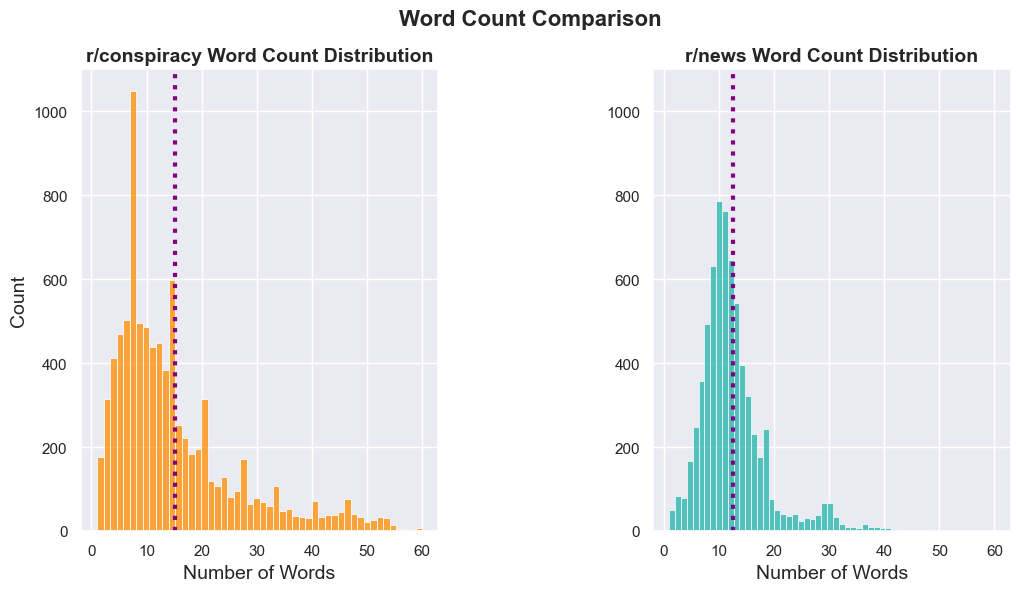

In [728]:
#plot comparison of word count distributions
custom_histplot("title_word_count", "Number of Words",
                "Word Count Distribution", "Word Count Comparison" )

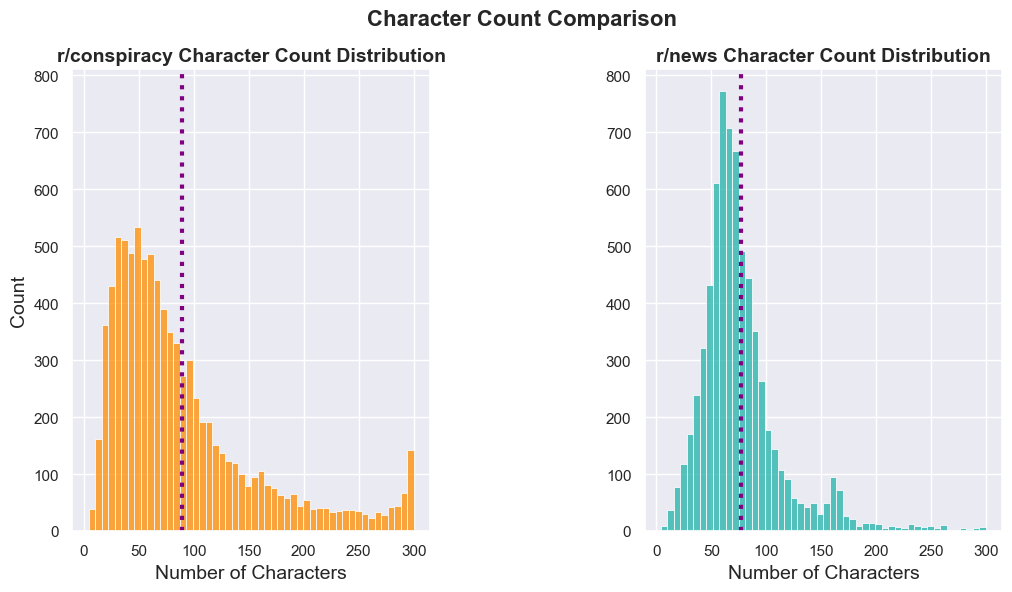

In [729]:
#plot comparison of post length distributions
custom_histplot("title_length", "Number of Characters",
                "Character Count Distribution", "Character Count Comparison" )

Greater spread of r/conspiracy variables is evident from the two histogram plots. Both distributions are right skewed.

### Sentiment Distribution

In [699]:
#summary statistics for r/conspiracy and r/news sentiment compound polarity score
df.groupby("subreddit")["sentiment"].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
conspiracy,8776.0,-0.073148,0.398478,-0.9753,-0.3612,0.0,0.0258,0.9936
news,6895.0,-0.034659,0.399169,-0.9801,-0.3182,0.0,0.2023,0.9852


Sentiment polarity score statisitics appear to be very similar. Both means are nearly zero and both median values are zero. Standard deviation values are nearly idential as well. Main difference is 3rd quartile value.

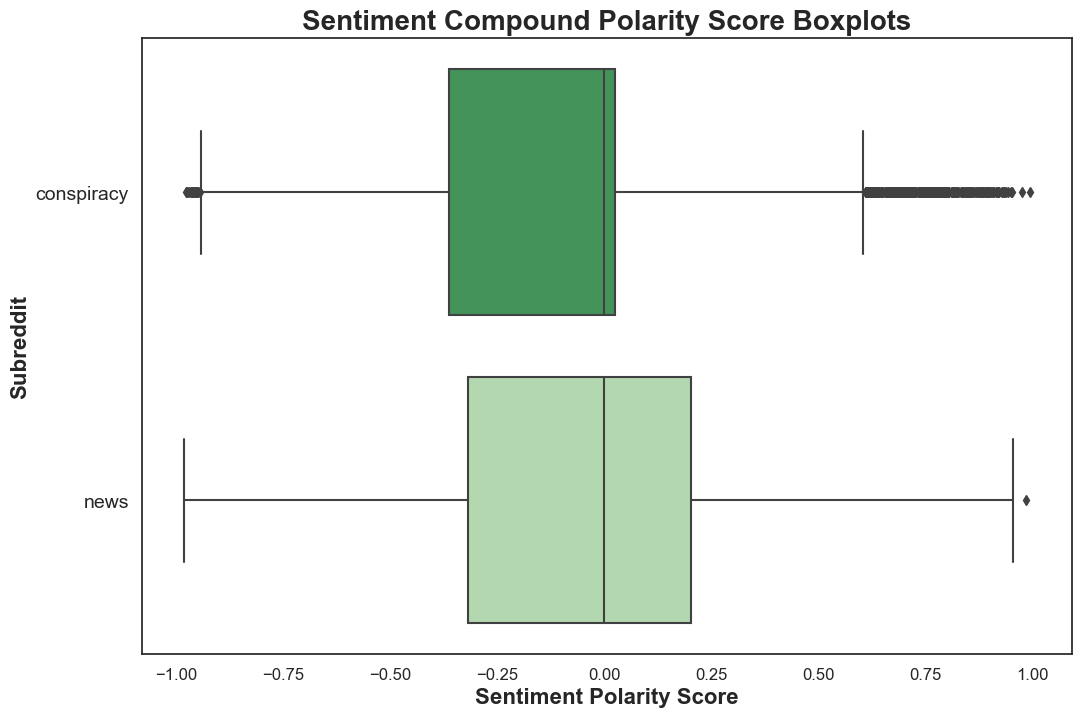

In [700]:
#plot boxplot of sentiment compound polarity scores
fig, ax = plt.subplots(figsize=(12,8))
sns.set(style = "white")
sns.boxplot(x = "sentiment", y = "subreddit", data = df, orient = "h",palette = "Greens_r")
plt.xlabel("Sentiment Polarity Score", fontweight = "bold", fontsize = 16)
plt.ylabel("Subreddit", fontweight = "bold", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 14)
plt.title("Sentiment Compound Polarity Score Boxplots", fontsize = 20, fontweight = "bold")
plt.savefig("../images/sentiment_polarity_score_boxplot.png");

In [682]:
#find percent of polarity score values that are positive outliers in r/conspiracy data
c_iqr = iqr(df_c["sentiment"])
sentiment_max = .0258 + (1.5*c_iqr)
round(len(df_c.loc[df_c["sentiment"] > sentiment_max])/len(df_c)*100,3)

5.583

About 6% of positive compound polarity scores are outliers for r/conspiracy data. 

In [749]:
#create custom comparsion frequency barplots

sns.set(style="darkgrid")

def custom_barplot(variable, x_label, plot_title, main_title):
    fig, ax =  plt.subplots(1, 2, figsize=(10,6), sharey = True)
    sns.barplot(x=df_c[variable].value_counts().index, y = df_c[variable].value_counts\
                  (normalize = True),ax=ax[0],  color = 'darkorange', alpha = 0.75,
              order=df_c[variable].value_counts(ascending=True).index)
    ax[0].set_xlabel(x_label, fontsize = 14)
    ax[0].set_ylabel("Frequency",fontsize = 14)
    ax[0].set_title(f"r/conspiracy {plot_title}", fontweight = "bold", fontsize = 14)
    
    sns.barplot(x=df_n[variable].value_counts().index, y = df_n[variable].value_counts\
                  (normalize = True), ax=ax[1],color = 'lightseagreen', alpha = 0.75,
             order=df_n[variable].value_counts(ascending=True).index)
    ax[1].set_xlabel(x_label, fontsize = 14)
    ax[1].set_ylabel("Frequency",fontsize = 14)
    ax[1].set_title(f"r/news {plot_title}", fontweight = "bold", fontsize = 14)
    ax[1].tick_params(labelleft = True)
    
    fig.suptitle(main_title, fontsize = 16, fontweight = "bold")
    plt.subplots_adjust(wspace=0.6)
    plt.savefig(f"../images/{plot_title.replace(' ', '_')}");


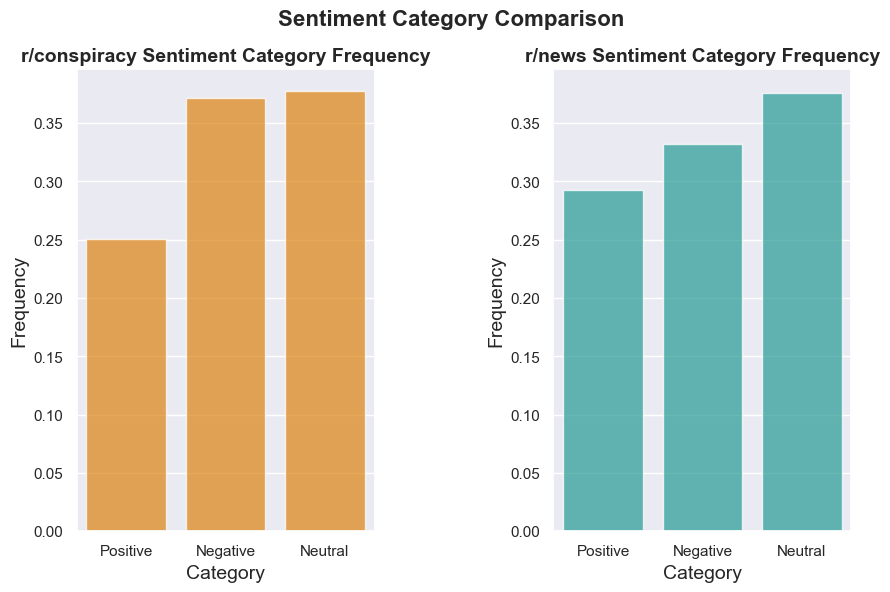

In [750]:
custom_barplot("sentiment_category", "Category",
                 "Sentiment Category Frequency", "Sentiment Category Comparison")

For the Conspiracy subreddit, posts with negative and neutral sentiments appear roughly the same amount. Positive posts are deemed to appear noticeably less frequently. The ranking order for the News subreddit sentiment frequencies are the same but the disparity between the negative and neutral categories is more pronounced. Additionally, postive sentiment posts occur more frequently relative to the other categories.

### Posting Time Analysis

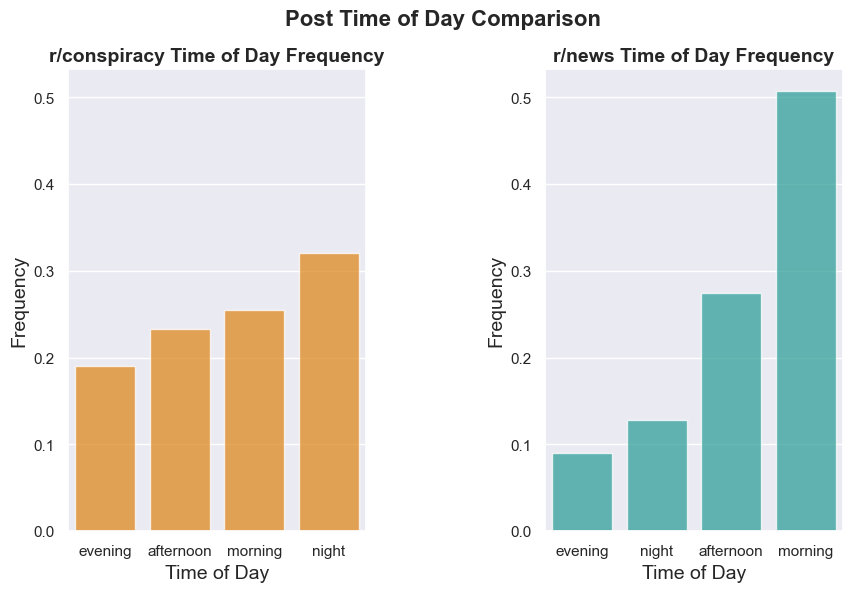

In [751]:
custom_barplot("hour", "Time of Day",
                 "Time of Day Frequency", "Post Time of Day Comparison")

Interestingly, most posts on r/conspiracy are made during the night. For r/news, the vast majority are created during the morning. The frequencies for r/conspiracy are relatively close whereas for r/news there is an enormous drop-off between the activity during the morning and other times of the day. It appears that conspiracy theoriests on reddit are engaged throughout the day whereas members of r/news integrate their activity into their morning and afternoon routines.

### Comparison of Top N-grams

In [769]:
# Make a list of stop words to add to english stop words
extra_words = ['just', 'like', 'us', 'get', 'going', 'would']

# Append created list to english stopwords list
stop_list = stopwords.words("english")
stop_list += extra_words

In [792]:
#vectorize text to perform analysis on n grams

def vectorize(ngram):
    cv = CountVectorizer(stop_words = stop_list, ngram_range=ngram)
    
    #apply transformation to posts in each subreddit data file
    #convert to dataframes
    n_vect = cv.fit_transform(df_n["title"])
    n_vect_df = pd.DataFrame(n_vect.todense(), columns = cv.get_feature_names_out())

    c_vect = cv.fit_transform(df_c["title"])
    c_vect_df = pd.DataFrame(c_vect.todense(), columns = cv.get_feature_names_out())
    
    #find number of occurrences of each word in respective corpus
    top_news = n_vect_df.sum(axis=0)
    top_conspiracy = c_vect_df.sum(axis=0)

    #convert series into dataframe with word and count columns sorted by count
    df_top_news = pd.DataFrame(top_news, columns = ["count"])
    df_top_news['word'] = df_top_news.index
    df_top_news['frequency'] = df_top_news["count"]/len(df_n)*100
    df_top_news.sort_values(by='count',ascending=False, inplace=True)

    df_top_conspiracy = pd.DataFrame(top_conspiracy, columns = ["count"])
    df_top_conspiracy['word'] = df_top_conspiracy.index
    df_top_conspiracy['frequency'] = df_top_conspiracy["count"]/len(df_c)*100
    df_top_conspiracy.reset_index(drop=True, inplace=True)
    df_top_conspiracy.sort_values(by='count',ascending=False, inplace=True)
    
    return df_top_conspiracy,df_top_news

In [812]:
#create custom comparsion frequency barplots

sns.set_style("whitegrid")

def custom_barplot_word(df_c, df_n, plot_title, main_title,text):
    fig,ax = plt.subplots(1,2, figsize = (18,10),sharex=True)
    
    sns.barplot(data = df_c[:20], x='frequency', y = 'word',ax=ax[0], orient = 'h')
    ax[0].set_xlabel("Frequency (%)", fontsize = 20)
    ax[0].set_ylabel(text,fontsize = 20)
    ax[0].set_title(f"r/conspiracy {plot_title}", fontweight = "bold", fontsize = 20)
    ax[0].tick_params(labelsize=15)
    
    sns.barplot(data = df_n[:20], x='frequency', y = 'word',ax=ax[1], orient = 'h')
    ax[1].set_xlabel("Frequency (%)", fontsize = 20)
    ax[1].set_ylabel(text,fontsize = 20)
    ax[1].set_title(f"r/news {plot_title}", fontweight = "bold", fontsize = 20)
    ax[1].tick_params(labelsize=15)
    ax[1].tick_params(labelbottom = True)
    
    fig.suptitle(main_title, fontsize = 25, fontweight = "bold")
    plt.subplots_adjust(wspace=0.8)
    plt.savefig(f"../images/{main_title.replace(' ', '_')}");
    

#### Top 1-grams

In [817]:
df_top_c_words, df_top_n_words = vectorize((1,1))

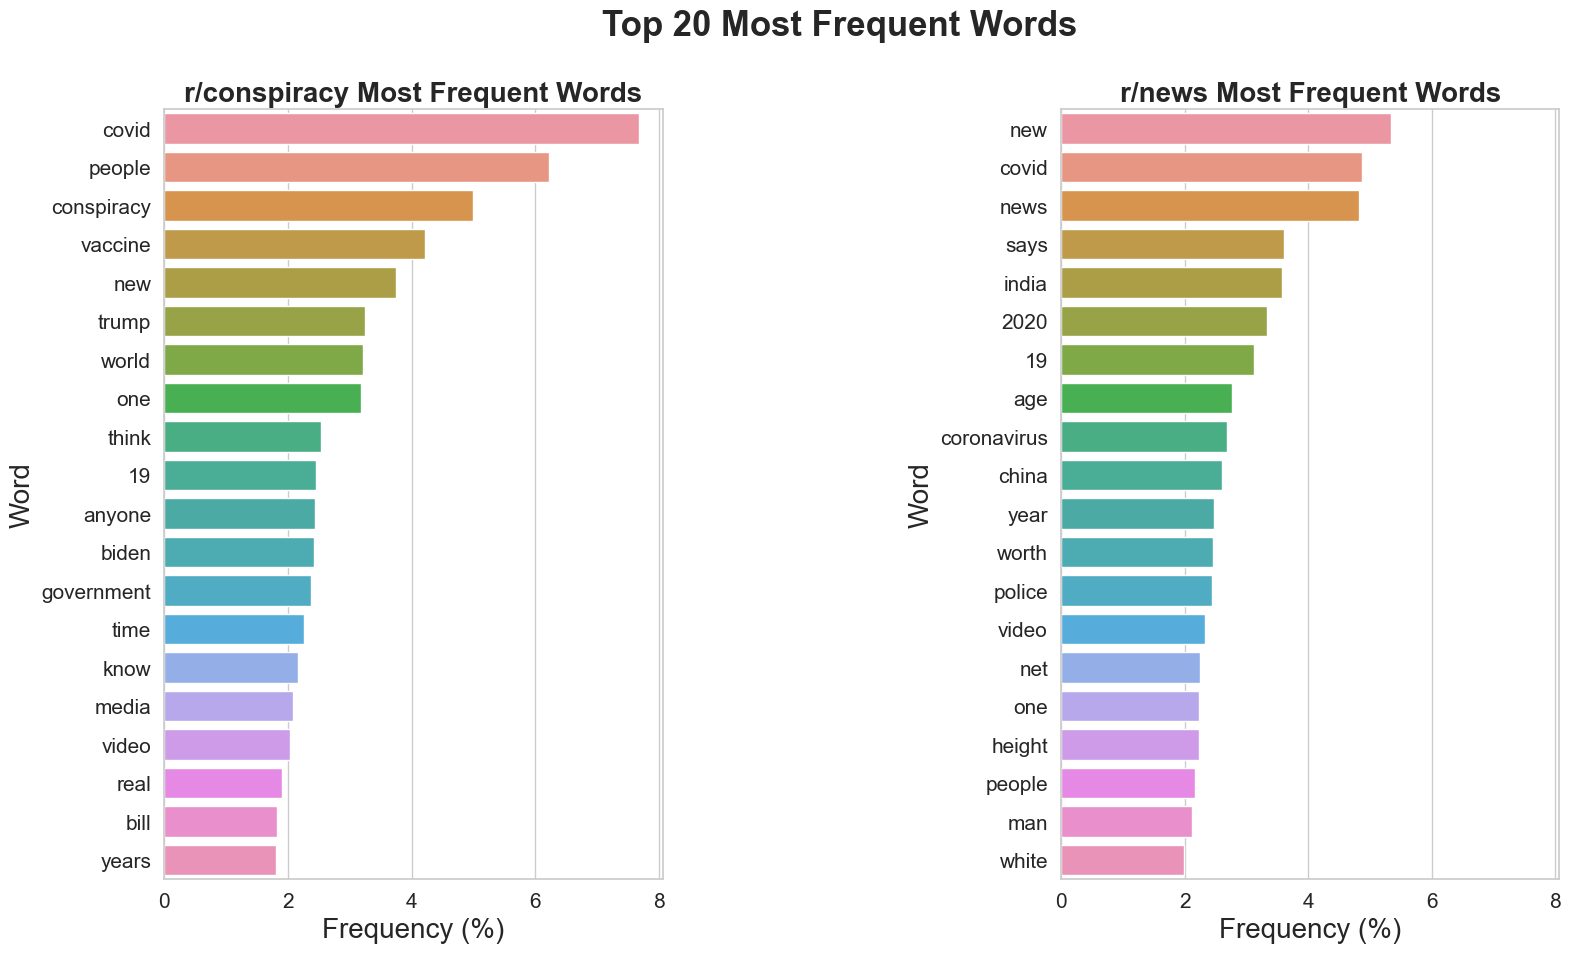

In [818]:
custom_barplot_word(df_top_c_words,df_top_n_words, "Most Frequent Words", "Top 20 Most Frequent Words", "Word")

Considering both datasets, no word appears in more than 8% of its respective corpus. Coronavirus seems to be important in both subreddits. Politics and world perspectives are common words in the Conspiracy subreddit. Foreign countries, policing, and more general terms appear to be popular in the News subreddit.

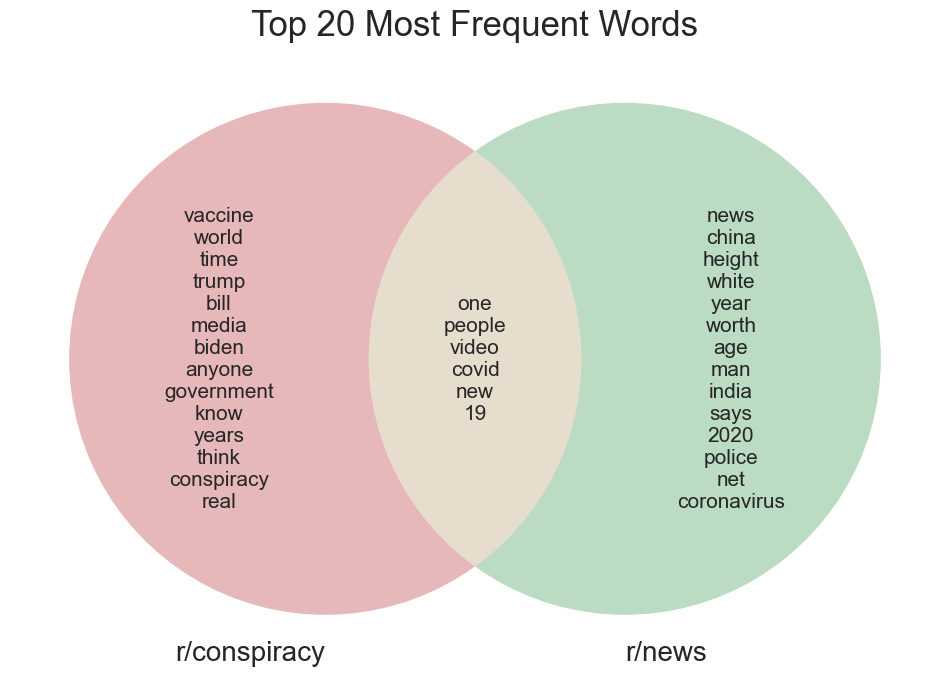

In [819]:
#Venn Diagram
#Source = https://towardsdatascience.com/how-to-create-and-customize-venn-diagrams-in-python-263555527305

plt.figure(figsize=(12,12))
plt.title('Top 20 Most Frequent Words',fontsize=25)

set_news = set(df_top_n_words['word'][:20])
set_conspiracy = set(df_top_c_words['word'][:20])

venn = venn2([set_conspiracy,set_news],set_labels=['r/conspiracy','r/news'])

venn.get_label_by_id('100').set_text('\n'.join(map(str,set_c-set_n)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_c&set_n)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_n-set_c)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(15)
venn.get_label_by_id('110').set_size(15)
venn.get_label_by_id('010').set_size(15)

plt.savefig("../images/top_20_words_venn.png")

Considering the top 20 most frequent words in each corpus, six words are highly used in both subreddits. As referenced above, coronavirus is a hot topic in both communities. The most common shared words will be added to the stopwords list in an attempt to boost model performance by creating greter separation in the most common terms of each corpus.

#### Top Bigrams

In [804]:
df_top_c_words, df_top_n_words = vectorize((2,2))

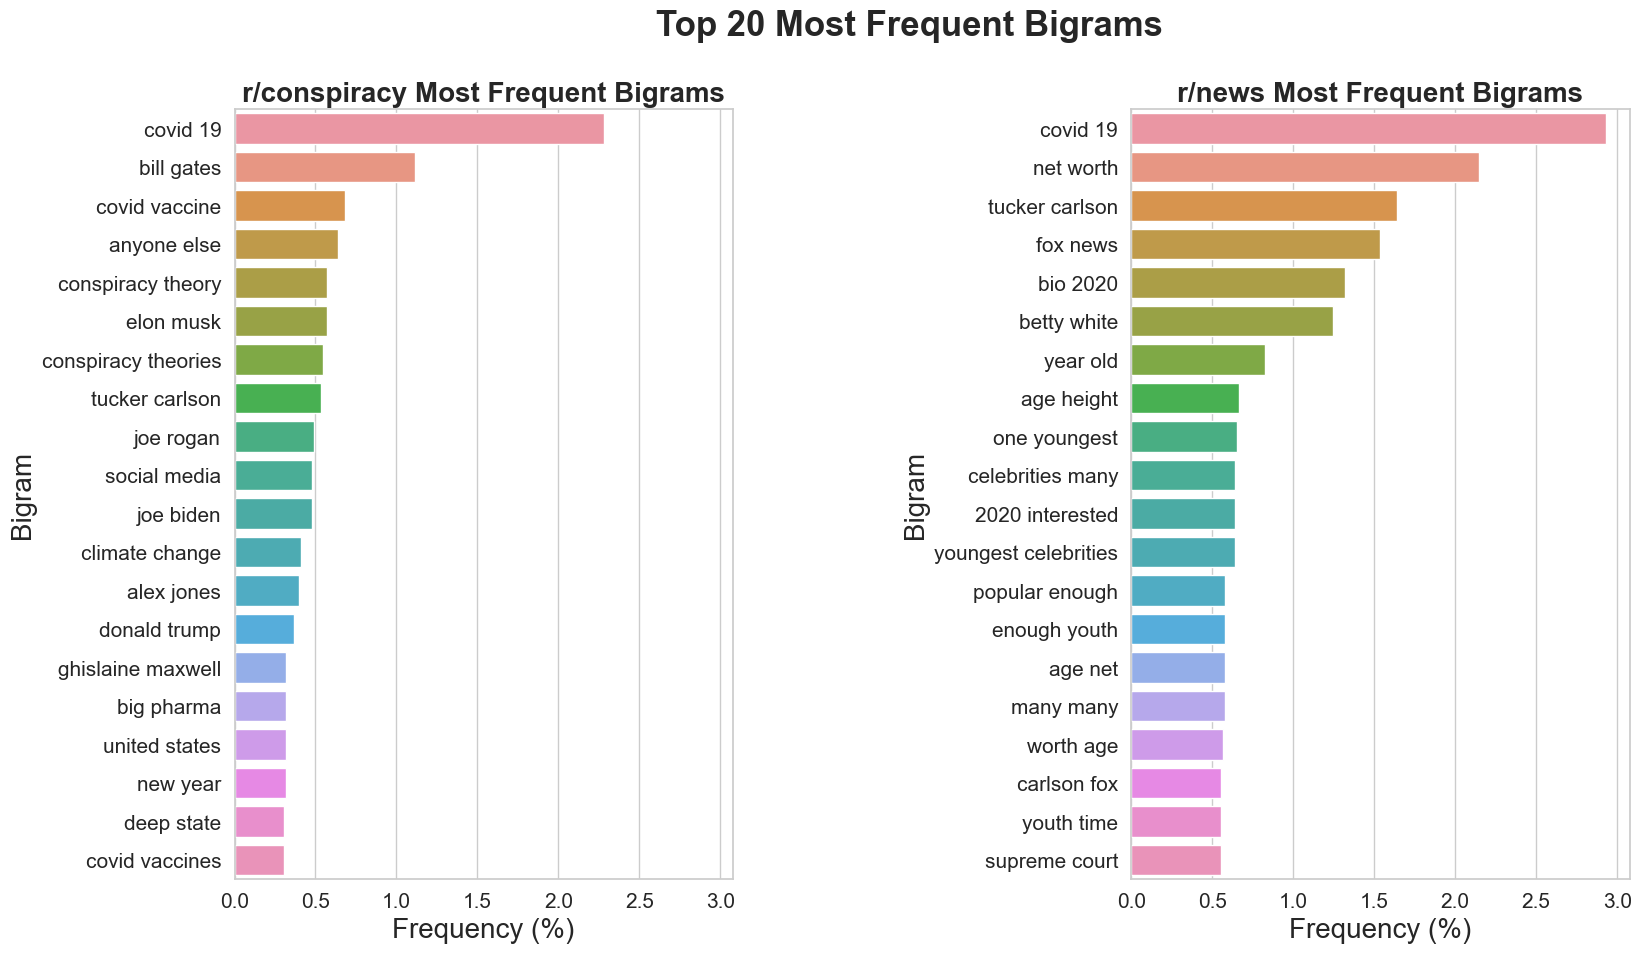

In [814]:
custom_barplot_word(df_top_c_words,df_top_n_words, "Most Frequent Bigrams", "Top 20 Most Frequent Bigrams", "Bigram")

Using bigrams allows one to see that several individuals are popular in both communities. Buzz words like "big pharma" and "deep state" are prevalent in the Conspiracy community. Some of the News' bigrams are difficult to interpret but their seems to be a pattern focusing on attributes of people such as age, height, and net worth. 

#### Top Trigrams

In [815]:
df_top_c_words, df_top_n_words = vectorize((3,3))

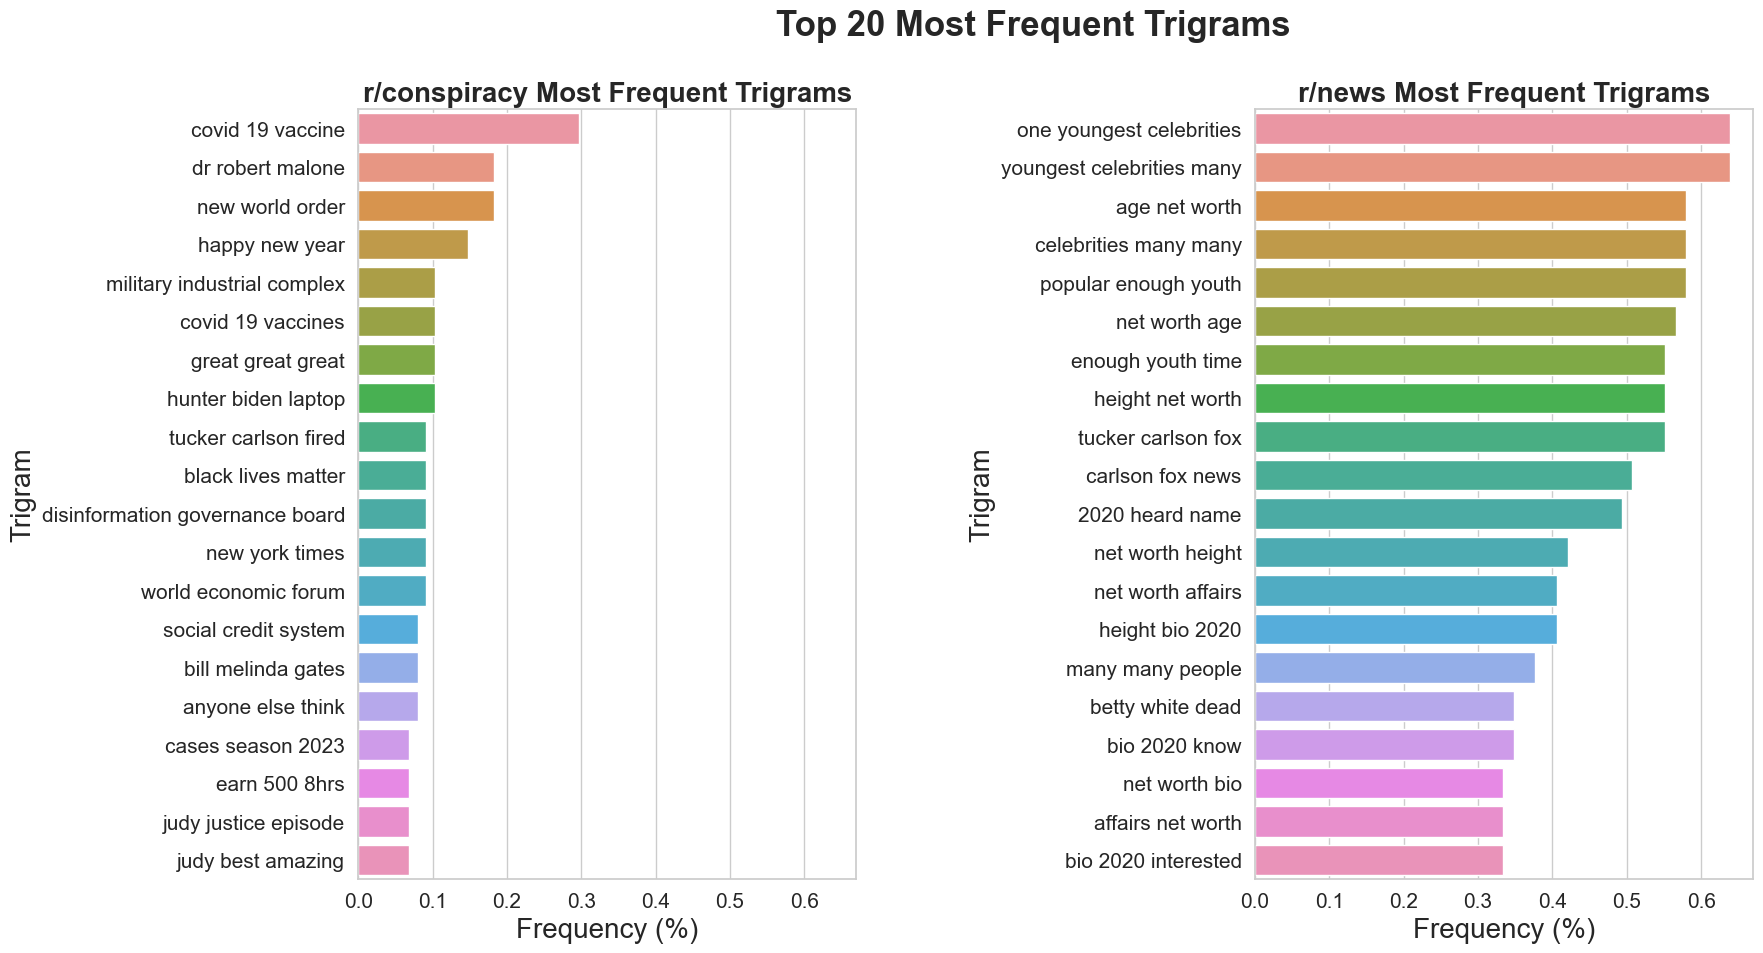

In [816]:
custom_barplot_word(df_top_c_words,df_top_n_words, "Most Frequent Trigrams", "Top 20 Most Frequent Trigrams", "Trigram")

As expected, trigrams occur much less frequently than smaller n-grams. One can see polarizing organizations and ideas present in the Conspiracy subreddit such as "black lives matter", "world economic forum", and "social credit system". News' subreddit appears to be much more disjointed  with phrases focused on celebreties and personal attributes as mentioned above. After some research through the dataset, it appears that the news subreddit contains quite a few spam-like posts that focus on celebrity gossip.

## Conclusions of EDA

Title length and title word count variables share many similarites across the two corpora. The main difference is the spread of the variables. There are small differences overall in the sentiment polarity score distributions but not enough to justify inclusion into the models. Time of day of post distributions seem to present an interesting perspective to include into the model. It was excluded, however, due to time constraints. There seem to be enough differences in the most frequent words and phrases present in each corpus to construct an effective classification model using only the post text. 

## Next Step:<a id='next_step_3'></a>
---

### [Modeling and Insights](./04_Modeling_and_Insights.ipynb)